In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

working in directory:
    `/gpfs/data/greenocean/software/products/ERA5_v202303_TJ`
    


## problem description:


- When downloading and processing ERA5 forcing, occasionally, the variable called `bulk_*_9_era5_daily.nc` gives a time dimension of time 0 (instead of 365/366), breaking the run
- 9 - 2m dewpoint temperature (shum.era) & surface pressure (pres.era) (notes in processERA5.sh) 


In [8]:
tdir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'

for y in range(1940,1970):
    # print(y)
    for b in range(8,15):
        try:
            #dst = f'{tdir}era5_bulk_{b}_y{y}.nc'
            dst = f'{tdir}bulk_{y}_{b}_era5_daily.nc'
            tfil = xr.open_dataset(dst, decode_times=False)
            noday = (tfil.time_counter.shape[0])
            nox = (tfil.x.shape[0])
            noy = (tfil.y.shape[0])
            if ((noday != 365) & (noday != 366)):
                print(f'processing problem year {y} bulk variable {b}')
            if ((nox != 182)):
                print(f'processing problem year {y} bulk variable {b}')
            if ((noy != 149)):
                print(f'processing problem year {y} bulk variable {b}')            
            # print(f'year {y} bulk variable (noday != 365) {b} GO!')
        except:
            print(f'failed to find for year {y} bulk variable {b}')
    try: 
        dst = f'{tdir}taux_1d_y{y}.nc'
        tfil = xr.open_dataset(dst, decode_times=False)
        noday = (tfil.time_counter.shape[0])
        nox = (tfil.x.shape[0])
        noy = (tfil.y.shape[0])
        if ((noday != 365) & (noday != 366)):
            print(f'processing problem year {y} taux')
        if ((nox != 182)):
            print(f'processing problem year {y} taux')
        if ((noy != 149)):
            print(f'processing problem year {y} taux')     
    except:
        print(f'failed to find for year {y} taux')

    try: 
        dst = f'{tdir}tauy_1d_y{y}.nc'
        tfil = xr.open_dataset(dst, decode_times=False)
        noday = (tfil.time_counter.shape[0])
        nox = (tfil.x.shape[0])
        noy = (tfil.y.shape[0])
        if ((noday != 365) & (noday != 366)):
            print(f'processing problem year {y} tauy')
        if ((nox != 182)):
            print(f'processing problem year {y} tauy')
        if ((noy != 149)):
            print(f'processing problem year {y} tauy')     
    except:
        print(f'failed to find for year {y} tauy')
        


print('analysis complete')

processing problem year 1940 bulk variable 9
processing problem year 1949 bulk variable 9
processing problem year 1953 bulk variable 9
processing problem year 1958 bulk variable 9
processing problem year 1959 bulk variable 9
processing problem year 1960 bulk variable 9
processing problem year 1962 bulk variable 9
processing problem year 1963 bulk variable 9
processing problem year 1964 bulk variable 9
processing problem year 1968 bulk variable 9
analysis complete






#### So let's look at all the relevant files for year 1963 (which did not work) and for year 1961 (which did) and try to track down the problem. 


- I've made a directory called `/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/test_proc` in which I try to isolate the problem, rerunning on 1961 and 1963

there are 3 phases here:

1. The raw files from era:
    
        2m_dewpoint_temperature_ERA5_1961.nc
        surface_pressure_ERA5_1961.nc

        2m_dewpoint_temperature_ERA5_1963.nc 
        surface_pressure_ERA5_1963.nc

2. the preprocessed files, step 1

        shum.era.1961.daily.nc
        pres.era.1961.daily.nc

        shum.era.1963.daily.nc
        pres.era.1963.daily.nc

3. the final preprocessed files (that are also symlinked)
        bulk_1963_9_era5_daily.nc
        bulk_1961_9_era5_daily.nc
        
Looking at the intermediate files `(shum.*),` they seem to have problems (time dimension of size 0) final preprocessed files do. 

        [mep22dku@c0007 /gpfs/data/greenocean/software/products/ERA5_v202303_TJ]$ ls shum*

        -rw-r--r-- 1 mep22dku greenocean 1515840804 Apr 16 09:57 shum.era.1966.daily.nc
        -rw-r--r-- 1 mep22dku greenocean 1515840804 Apr 16 09:58 shum.era.1965.daily.nc
        -rw-r--r-- 1 mep22dku greenocean 1515840804 Apr 16 10:06 shum.era.1967.daily.nc
        -rw-r--r-- 1 mep22dku greenocean 1515840804 Apr 16 10:15 shum.era.1969.daily.nc
        -rw-r--r-- 1 mep22dku greenocean  240880856 Apr 18 12:09 shum.era.1940.daily.nc
        -rw-r--r-- 1 mep22dku greenocean   74762296 Apr 18 12:09 shum.era.1949.daily.nc
        -rw-r--r-- 1 mep22dku greenocean   95527116 Apr 18 12:09 shum.era.1953.daily.nc
        -rw-r--r-- 1 mep22dku greenocean   24926728 Apr 18 12:09 shum.era.1958.daily.nc
        -rw-r--r-- 1 mep22dku greenocean   12467836 Apr 18 12:09 shum.era.1959.daily.nc
        -rw-r--r-- 1 mep22dku greenocean    8314872 Apr 18 12:09 shum.era.1960.daily.nc
        
#### However

I've put all the raw downloaded ERA files for the years that had problems in a subdirectory and tried to rerun the processing on them again:

/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/PATCH_HOLE

Now the shum* files are of the right size:

    [mep22dku@c0007 /gpfs/data/greenocean/software/products/ERA5_v202303_TJ/PATCH_HOLE]$ ls shum.era.19*
    -rw-r--r-- 1 mep22dku greenocean 1519993768 Apr 18 18:17 shum.era.1940.daily.nc
    -rw-r--r-- 1 mep22dku greenocean 1519993768 Apr 18 18:22 shum.era.1968.daily.nc
    -rw-r--r-- 1 mep22dku greenocean 1515840804 Apr 18 18:33 shum.era.1949.daily.nc
    -rw-r--r-- 1 mep22dku greenocean 1515840804 Apr 18 18:38 shum.era.1962.daily.nc
    
    
However the interpolation seems to not run, eg:

    /gpfs/data/greenocean/software/products/ERA5_v202303_TJ/PATCH_HOLE/forcing.1963_9_era5_daily.log
    04-18 18:49 Run          INFO     Output Dimensions [y,x]: [365, 149, 182]
    04-18 18:49 Run          INFO     Parameter: shum
    04-18 18:49 Run          INFO     Preprocessing: shum
    
As opposed to 

        /gpfs/data/greenocean/software/products/ERA5_v202303_TJ]$ vim forcing.1961_9_era5_daily.log
        04-16 09:39 Run          INFO     Dimensions: 149,182
        04-16 09:39 Run          INFO     Output Dimensions [y,x]: [365, 149, 182]
        04-16 09:39 Run          INFO     Parameter: shum
        04-16 09:39 Run          INFO     Preprocessing: shum
        04-16 09:41 Run          INFO     Interpolating perDay: shum
        04-16 09:41 Run          INFO     Time point: 0 for shum
        04-16 09:41 Run          INFO     Time point: 1 for shum
        04-16 09:41 Run          INFO     Time point: 2 for shum
        
So the shum files wrote incorrectly the first time. However they appear to have written fine when I reran in the PATCH_HOLE directory (but final file still not processed), which is inconsistent. 

SyntaxError: EOL while scanning string literal (1587477504.py, line 3)

### check raw files

In [9]:
tdir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/test_proc'

dp_temp_1961 = xr.open_dataset(f'{tdir}/2m_dewpoint_temperature_ERA5_1961.nc')
dp_temp_1963 = xr.open_dataset(f'{tdir}/2m_dewpoint_temperature_ERA5_1963.nc')

sp_1961 = xr.open_dataset(f'{tdir}/surface_pressure_ERA5_1961.nc')
sp_1963 = xr.open_dataset(f'{tdir}/surface_pressure_ERA5_1963.nc')

check raw file dewpoint temp - 1963 doesn't work, 1961 does
- both raw files look ok!

check raw file surface pressure - 1963 doesn't work, 1961 does
- both raw files look ok!

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


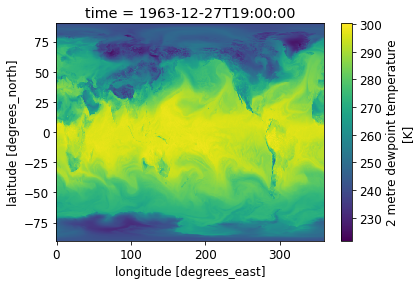

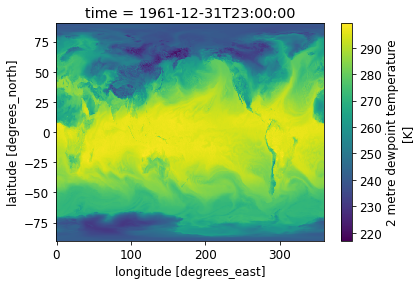

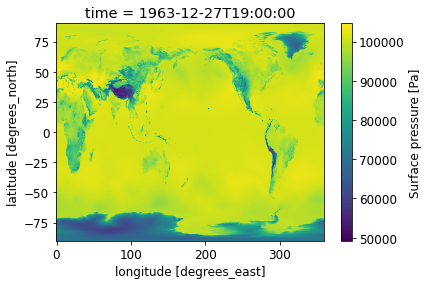

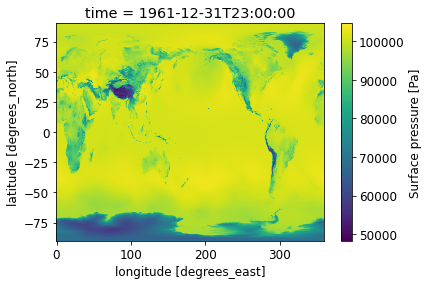

In [10]:
plt.figure()
xr.plot.pcolormesh(dp_temp_1963.d2m[8659,:,:])
plt.figure()
xr.plot.pcolormesh(dp_temp_1961.d2m[8759,:,:])

plt.figure()
xr.plot.pcolormesh(sp_1963.sp[8659,:,:])
plt.figure()
xr.plot.pcolormesh(sp_1961.sp[8759,:,:])